In [22]:
# Import necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Define file path and load all Excel files
folder_path = 'evaluation_rags'
excel_files = glob(os.path.join(folder_path, "*.csv"))

# Create an empty DataFrame to store all data
all_data = pd.DataFrame()

# Load data from each file and append it to the DataFrame
for file in excel_files:
    data = pd.read_csv(file)
    
    # Extract relevant config info from the file name
    file_info = os.path.basename(file).replace(".csv", "").split("_")
    optimizer = 'optimizer' in file_info
    index = file_info[0].split("-")[0]
    config = index + "_" + file_info[1]
    rag_model = file_info[1]
    additional_flags = "_".join([x for x in file_info if x in ["rerank", "rephrase", "enrich"]])
    additional_flags = additional_flags if additional_flags else "none"
    mode = "Direct" if "Direct" in file_info else "RAG"
    
    # Add extracted config info as new columns
    data['optimizer'] = optimizer
    data['config'] = config
    data['rag_model'] = rag_model
    data['additional_flags'] = additional_flags
    data['mode'] = mode
    data['index'] = index
    

    # Convert similarity_score to a numeric average if it's a list
    try:
        data['similarity_score'] = data['similarity_score'].apply(lambda x: sum(eval(x)) / len(eval(x)) if isinstance(x, str) else x)
    except Exception as e:
        print(f"Error converting similarity scores in file {file}: {e}")
        continue  # Skip files with errors
    
    all_data = pd.concat([all_data, data], ignore_index=True)

all_data['eval_correctness'] = all_data['eval_correctness'].apply(lambda x: 1 if x == "Correct" else 0)


# Ensure all eval columns are numeric for aggregation
for col in ['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence', 'eval_correctness']:
    all_data[col] = pd.to_numeric(all_data[col], errors='coerce')

# Plotting section
sns.set(style="whitegrid")

### Visual

In [23]:
def to_pastel(color):
    return sns.light_palette(color, n_colors=1, reverse=True)[0]


def get_warm_colors(n_colors):
    return [to_pastel(i) for i in sns.color_palette("YlOrRd", n_colors)]


def get_cold_colors(n_colors):
    return [to_pastel(i) for i in sns.color_palette("Blues", n_colors)]


def get_palette(two_n_colors):
    n_colors = two_n_colors // 2

    warm_colors = get_warm_colors(n_colors)
    cold_colors = get_cold_colors(n_colors)
    cold_colors.reverse()

    return cold_colors + warm_colors


def get_medians(data, group_by, column):
    return data.groupby(group_by)[column].median().sort_values(ascending=False)

In [24]:
# Create aggregated data for RAG mode
rag_all_data = all_data[all_data['mode'] == 'RAG']
rag_agg_data = rag_all_data.groupby(['config', 'additional_flags']).agg(
    mean_similarity_score=('similarity_score', 'mean'),
    mean_factuality=('eval_factuality', 'mean'),
    mean_relevance=('eval_relevance', 'mean'),
    mean_completeness=('eval_completeness', 'mean'),
    mean_confidence=('eval_confidence', 'mean'),
    mean_correctness=('eval_correctness', 'mean'),
).reset_index()

rag_agg_data['mean_overall_score'] = rag_agg_data[['mean_factuality', 'mean_relevance', 'mean_completeness', 'mean_confidence']].mean(axis=1)
rag_agg_data['median_overall_score'] = rag_agg_data[['mean_factuality', 'mean_relevance', 'mean_completeness', 'mean_confidence']].median(axis=1)

## Overall Score Distribution over Configurations

In [25]:
# Select top 10 and low 10 configurations by median overall score
rag_top_10_by_overall_score = rag_agg_data.nlargest(10, 'median_overall_score')
rag_low_10_by_overall_score = rag_agg_data.nsmallest(10, 'median_overall_score')
rag_relevant_confings_and_flags = pd.concat([rag_top_10_by_overall_score, rag_low_10_by_overall_score])[['config', 'additional_flags']].drop_duplicates()

In [26]:
# Calculate overall score and merge with relevant configurations and flags
rag_all_data['overall_score'] = rag_all_data[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)
proccessed_data = rag_all_data.merge(rag_relevant_confings_and_flags, on=['config', 'additional_flags'])
proccessed_data['setup'] = proccessed_data['config'] + "_" + proccessed_data['additional_flags']
medians = get_medians(proccessed_data, 'setup', 'overall_score')
proccessed_data['setup'] = pd.Categorical(proccessed_data['setup'], categories=medians.index, ordered=True)
palette = get_palette(20)
color_mapping = {setup: palette[i] for i, setup in enumerate(medians.index)}

/tmp/ipykernel_2799/1311470223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rag_all_data['overall_score'] = rag_all_data[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)


/tmp/ipykernel_2799/4051368942.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='overall_score', y='setup', data=proccessed_data, orient='h', width=0.5, palette=color_mapping)


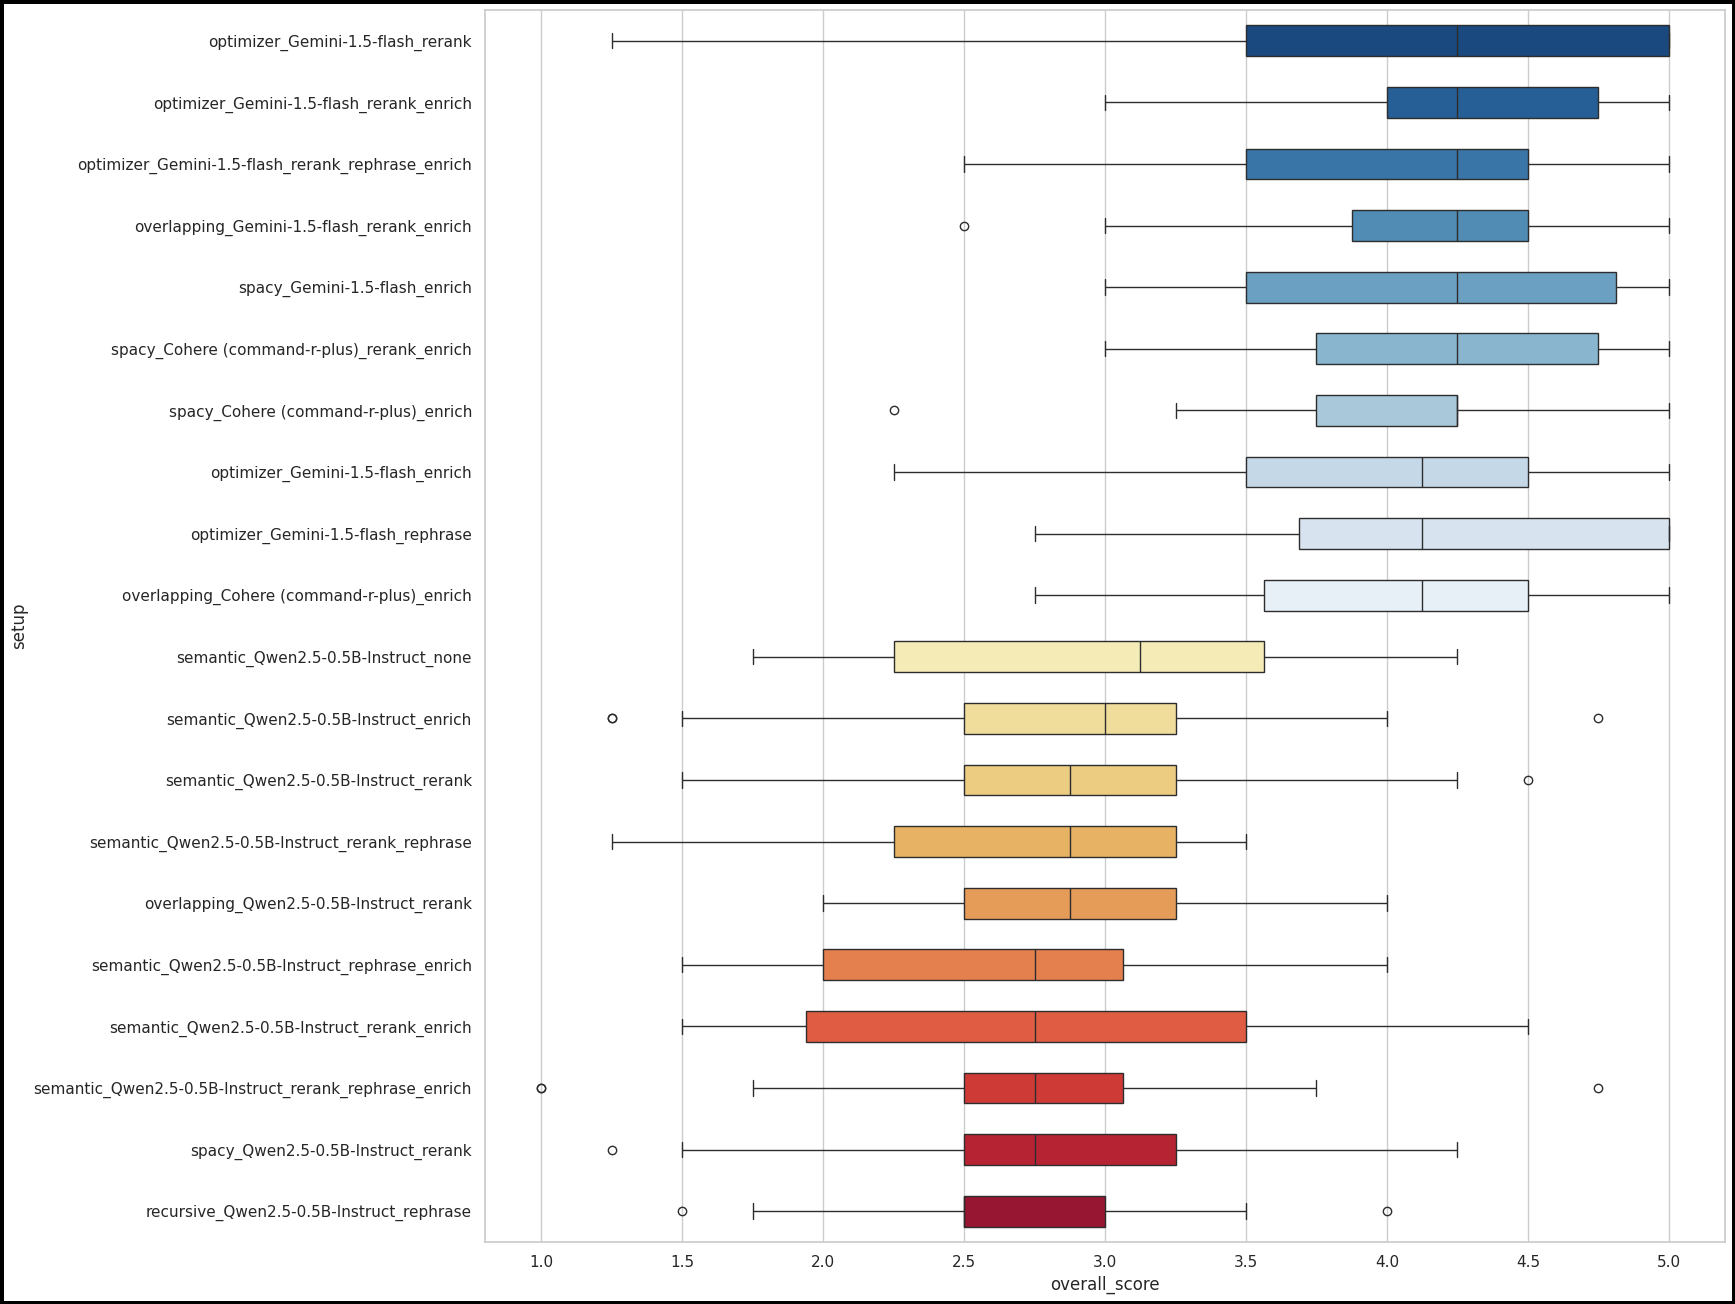

In [27]:
# Plot the boxplot
fig = plt.figure(figsize=(16, 16))
fig.patch.set_edgecolor('black')
fig.patch.set_linewidth(5)
sns.boxplot(x='overall_score', y='setup', data=proccessed_data, orient='h', width=0.5, palette=color_mapping)
plt.show()

## Optimizer choice distribution

/tmp/ipykernel_2799/4167464263.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Recursive Search index', 'Recursive Chunking')
/tmp/ipykernel_2799/4167464263.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Spacy NLP index', 'SpaCy-Based Chunking')
/tmp/ipykernel_2799/4167464263.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

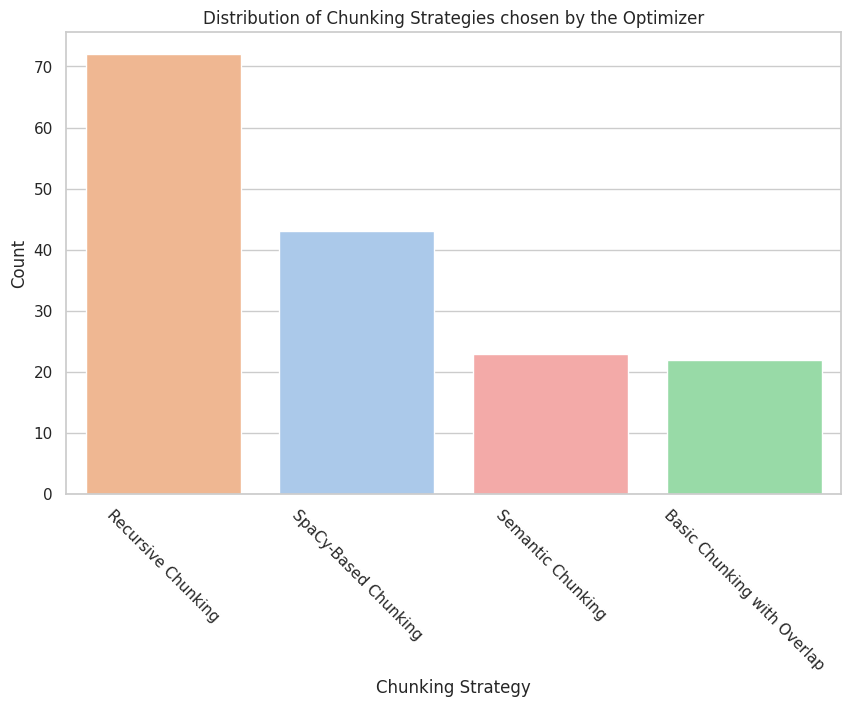

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define your custom pastel colors as a list of hex codes or color names
custom_palette = ['#ffb482', '#a1c9f4','#ff9e9b', '#8de5a1']  # Example pastel colors

# Filter data for optimizer configurations in RAG mode
optimizer_data = all_data[all_data['optimizer'] & (all_data['mode'] == 'RAG')]

# Replace occurrences of 'None' with meaningful names for the optimal_index
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Recursive Search index', 'Recursive Chunking')
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Spacy NLP index', 'SpaCy-Based Chunking')
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Semantic Match index', 'Semantic Chunking')
optimizer_data['optimal_index'] = optimizer_data['optimal_index'].replace('Overlap Strategy index', 'Basic Chunking with Overlap')

# Display the count of each unique value in the 'optimal_index' column
optimizer_data['optimal_index'].value_counts()

# Create the plot with your custom pastel color palette
plt.figure(figsize=(10, 6))
plt.xticks(rotation=-45)

sns.countplot(x='optimal_index', data=optimizer_data, palette=custom_palette)

plt.title("Distribution of Chunking Strategies chosen by the Optimizer")
plt.xlabel("Chunking Strategy")
plt.ylabel("Count")

# Show the plot
plt.show()


## Enhancements Comparison

/tmp/ipykernel_2799/772212172.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rag_all_data['overall_score'] = rag_all_data[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)
/tmp/ipykernel_2799/772212172.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rag_all_data['additional_flags'] = pd.Categorical(rag_all_data['additional_flags'], categories=means.index, ordered=True)
/tmp/ipykernel_2799/772212172.py:18: FutureWarning: 

Passing `palette` without assignin

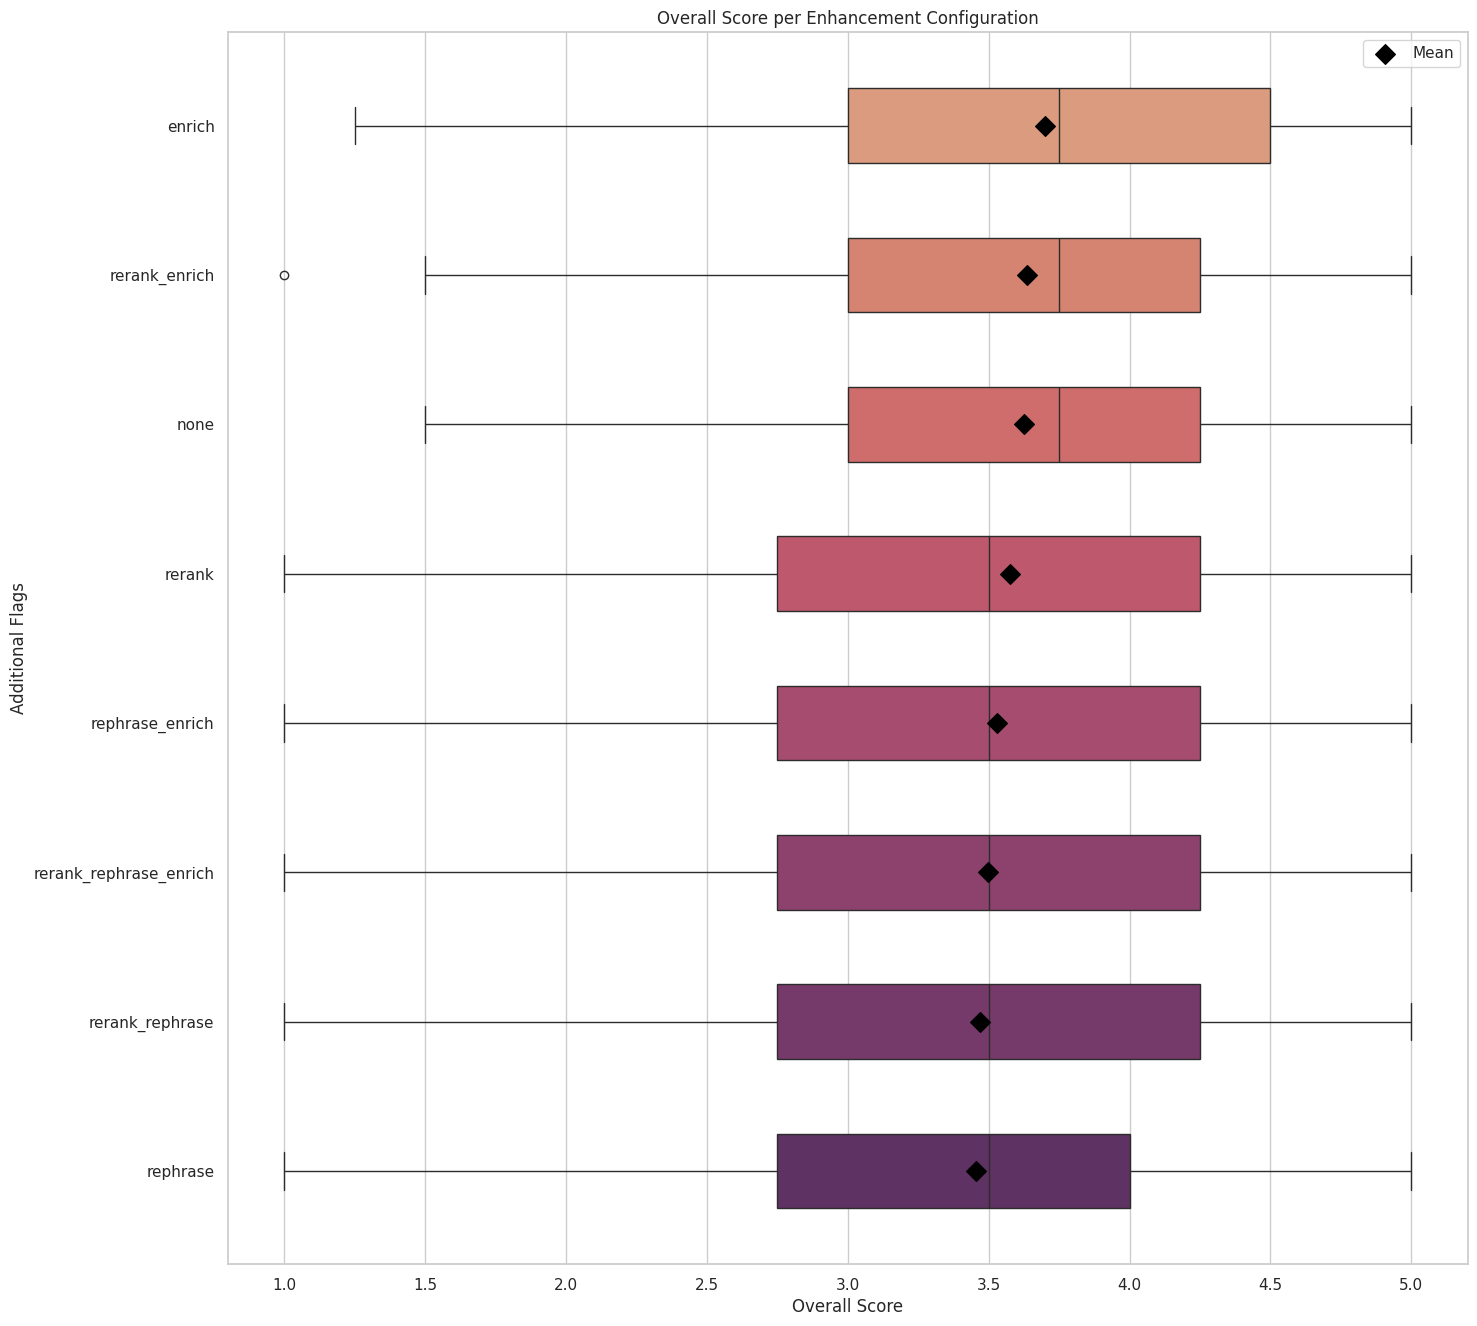

In [29]:
# Filter data for RAG mode
rag_all_data = all_data[all_data['mode'] == 'RAG']

# Calculate the overall score for each row by averaging relevant eval columns
rag_all_data['overall_score'] = rag_all_data[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)

# Get medians for sorting the boxplot
medians = rag_all_data.groupby('additional_flags')['overall_score'].median().sort_values(ascending=False)

# Calculate the mean of 'overall_score' for each 'additional_flags' group
means = rag_all_data.groupby('additional_flags')['overall_score'].mean().sort_values(ascending=False)

# Reorder 'additional_flags' based on median values
rag_all_data['additional_flags'] = pd.Categorical(rag_all_data['additional_flags'], categories=means.index, ordered=True)

# Plot the boxplot
plt.figure(figsize=(16, 16))
sns.boxplot(x='overall_score', y='additional_flags', data=rag_all_data, orient='h', width=0.5, palette='flare')


# Overlay the mean values on the boxplot
# mean_points = means.reindex(medians.index)
plt.scatter(means, means.index, color='black', marker='D', s=100, label='Mean', zorder=10)

# Add legend and title
plt.legend()
plt.title("Overall Score per Enhancement Configuration")
plt.xlabel("Overall Score")
plt.ylabel("Additional Flags")
plt.show()


## Indexing and Enhancements Comparison

/tmp/ipykernel_2799/1889037671.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flag_data['index'] = pd.Categorical(flag_data['index'], categories=medians.index, ordered=True)
/tmp/ipykernel_2799/1889037671.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='similarity_score', y='index', data=flag_data, orient='h', width=0.5, palette='pastel', ax=axes[i])
/tmp/ipykernel_2799/1889037671.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

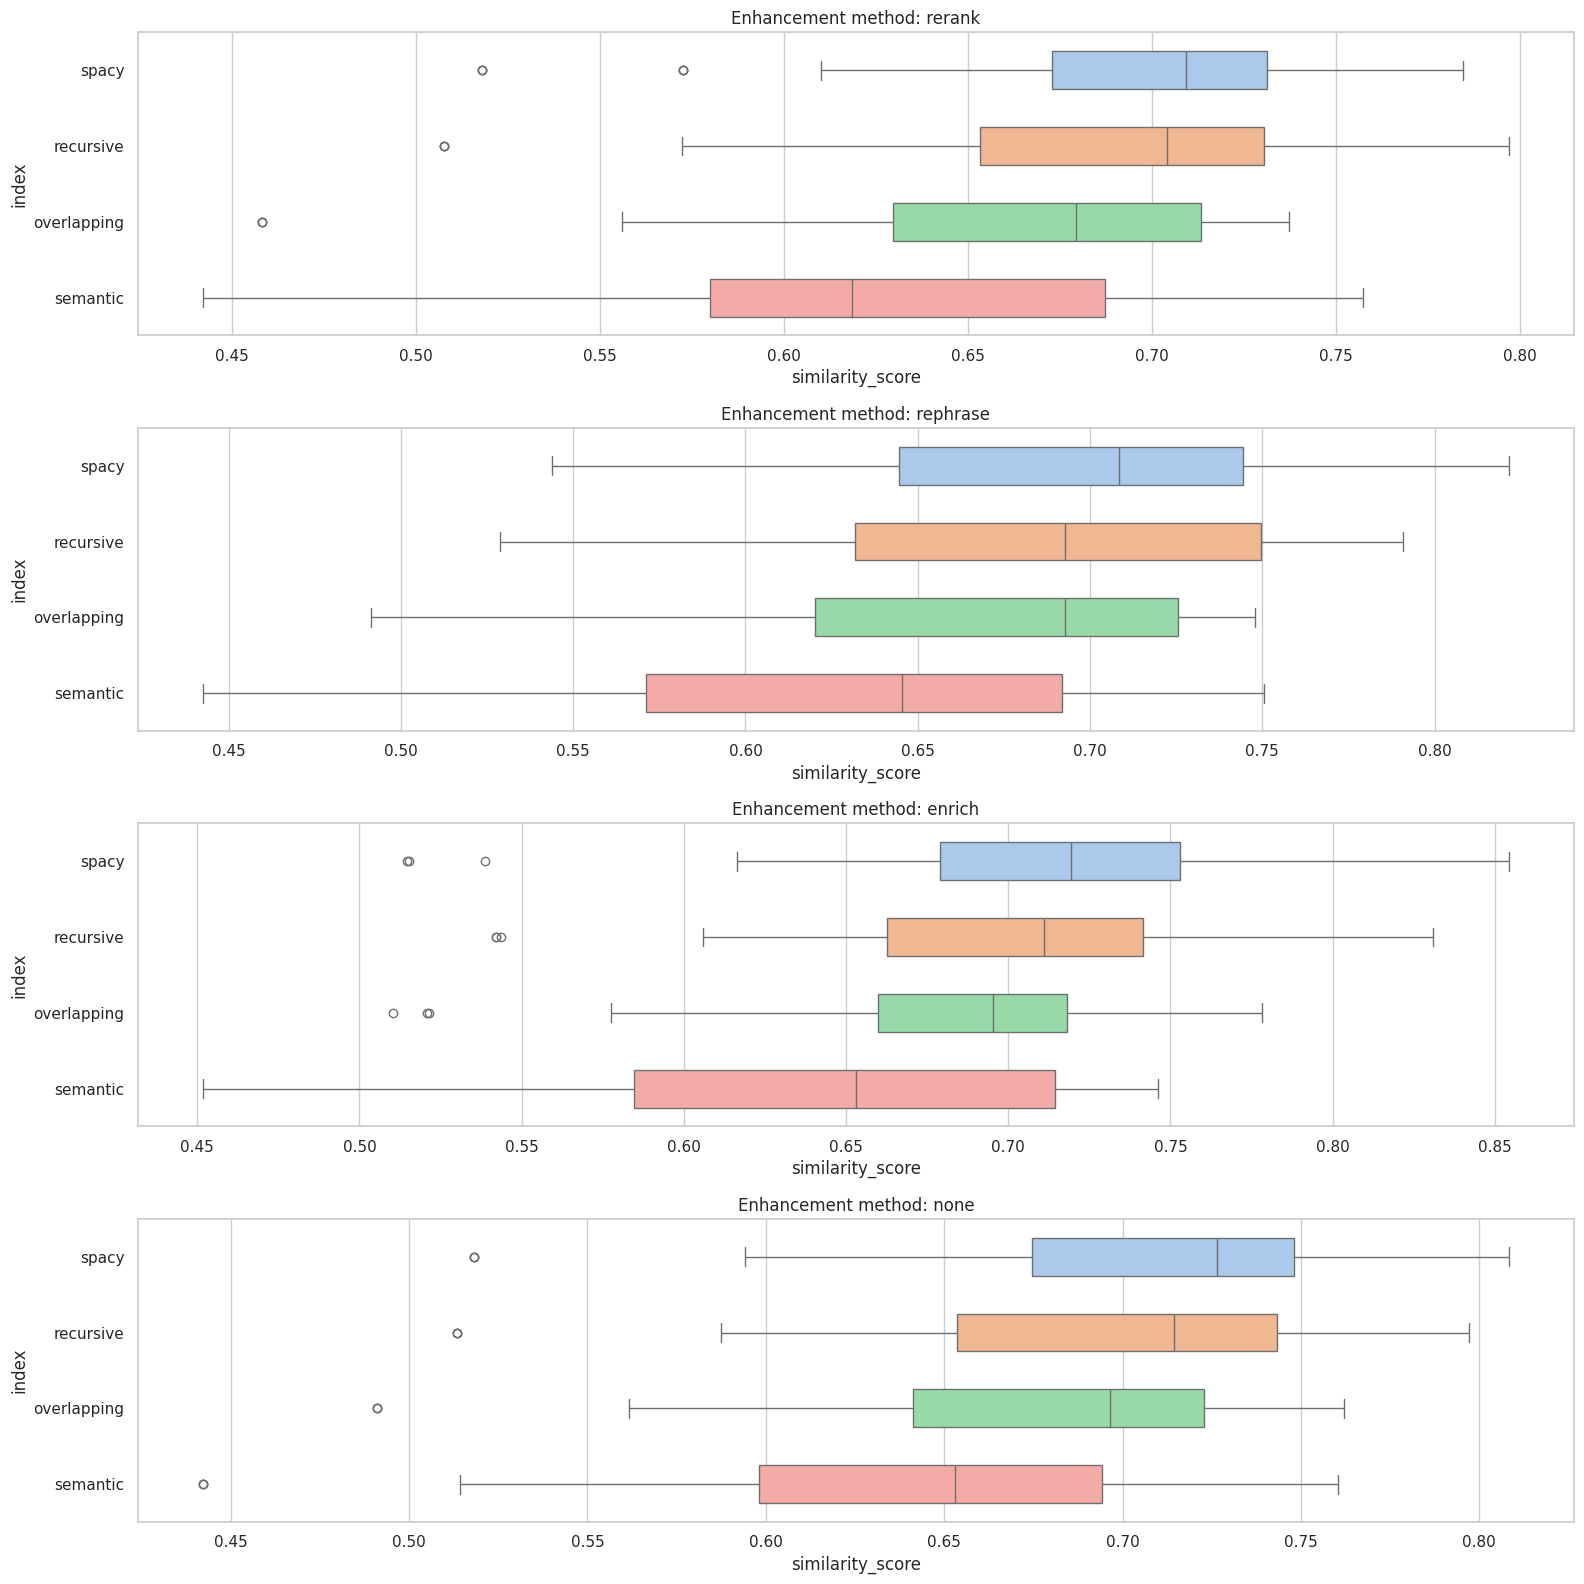

In [30]:
flags = ['rerank', 'rephrase', 'enrich', 'none']
warm_colors = get_warm_colors(6)
cold_colors = get_cold_colors(6)
cold_colors.reverse()
palette = cold_colors + warm_colors

# Create a figure with subplots
fig, axes = plt.subplots(nrows=len(flags), ncols=1, figsize=(16, 4 * len(flags)))

for i, flag in enumerate(flags):
    flag_data = all_data[(all_data['additional_flags'] == flag) & (all_data['mode'] == 'RAG') & (~all_data['optimizer'])]
    medians = flag_data.groupby('index')['similarity_score'].median().sort_values(ascending=False)
    flag_data['index'] = pd.Categorical(flag_data['index'], categories=medians.index, ordered=True)

    # Plot the boxplot in the respective subplot
    sns.boxplot(x='similarity_score', y='index', data=flag_data, orient='h', width=0.5, palette='pastel', ax=axes[i])
    axes[i].set_title(f'Enhancement method: {flag}')

# Adjust layout
plt.tight_layout()
plt.show()

## Indexing Comparison

/tmp/ipykernel_2799/730502602.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['index'] = pd.Categorical(plot_data['index'], categories=medians.index, ordered=True)
/tmp/ipykernel_2799/730502602.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='similarity_score', y='index', data=plot_data, orient='h', width=0.5, palette='pastel')


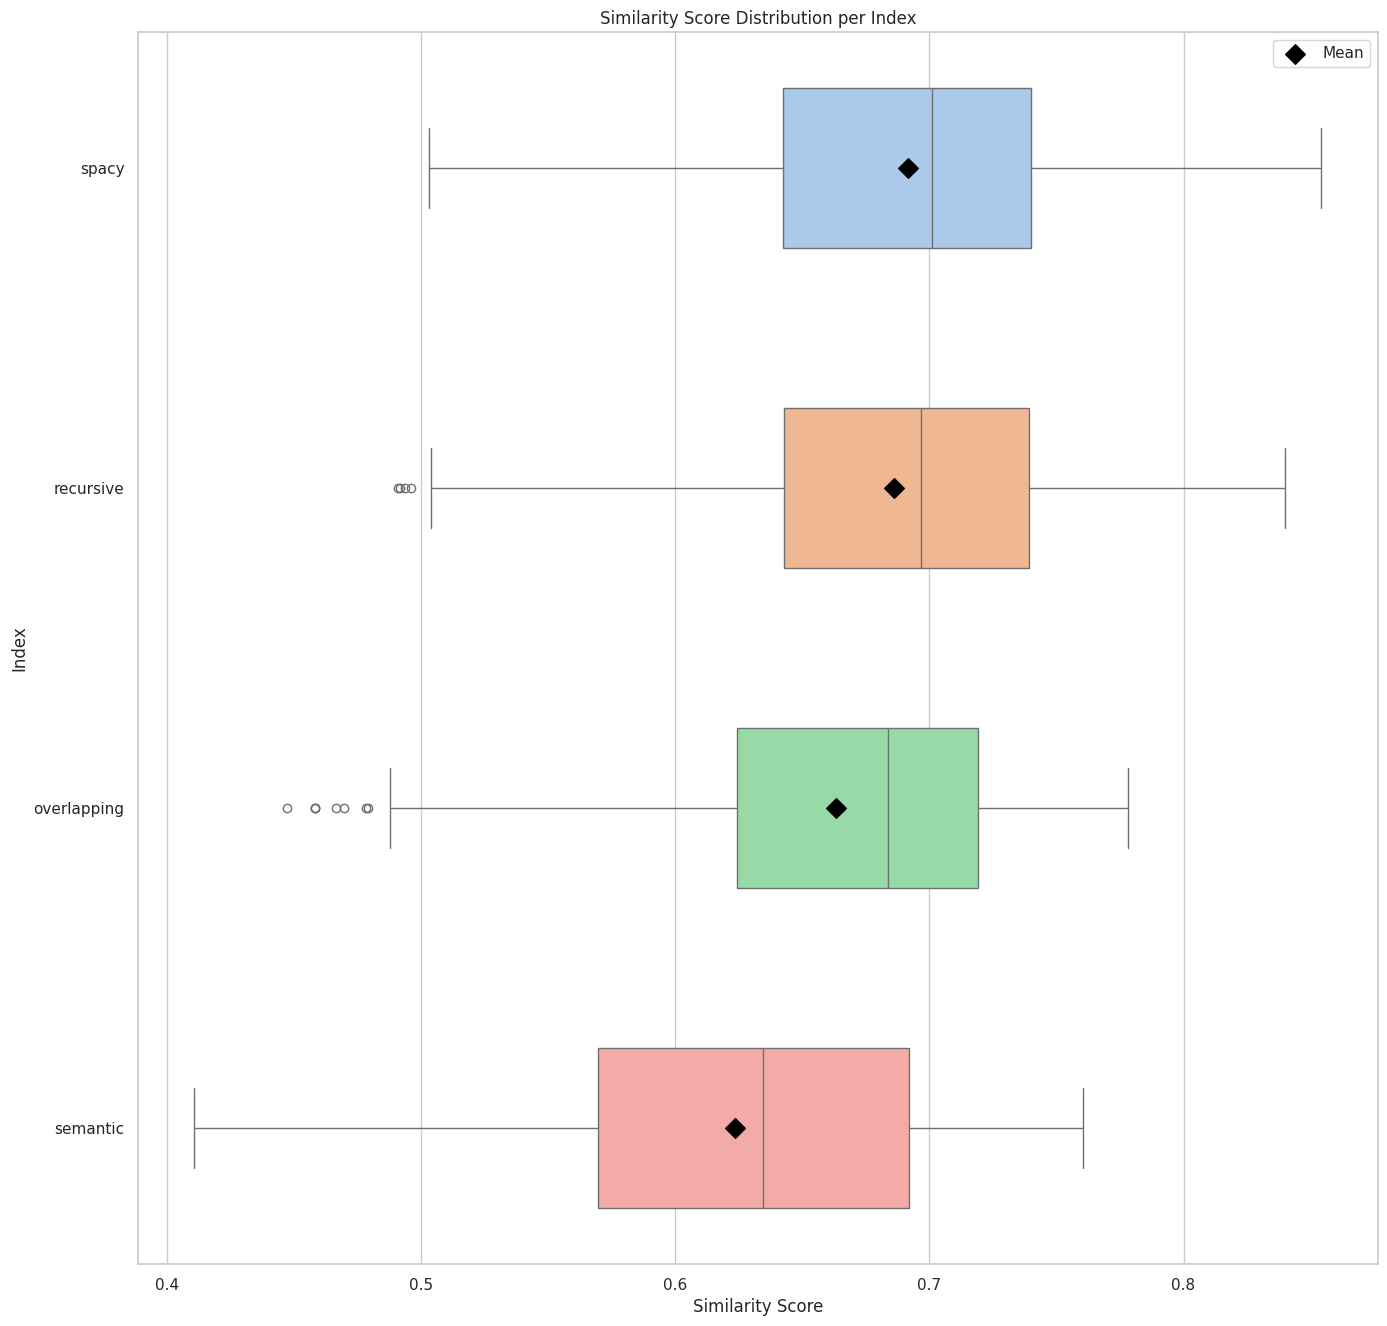

In [31]:
# Filter data for RAG mode without optimizer
plot_data = all_data[(all_data['mode'] == 'RAG') & (~all_data['optimizer'])]

# Calculate the median for sorting and the mean for plotting
medians = plot_data.groupby('index')['similarity_score'].median().sort_values(ascending=False)
means = plot_data.groupby('index')['similarity_score'].mean()

# Order the 'index' category based on the median values
plot_data['index'] = pd.Categorical(plot_data['index'], categories=medians.index, ordered=True)

# Plot the boxplot
plt.figure(figsize=(16, 16))
sns.boxplot(x='similarity_score', y='index', data=plot_data, orient='h', width=0.5, palette='pastel')

# Overlay the mean values on the boxplot
mean_points = means.reindex(medians.index)
plt.scatter(mean_points, mean_points.index, color='black', marker='D', s=100, label='Mean',zorder=10)

# Add legend and title
plt.legend()
plt.title("Similarity Score Distribution per Index")
plt.xlabel("Similarity Score")
plt.ylabel("Index")
plt.show()


## Table printing in latex format

In [32]:
# Save and aggregate data without optimizer
data_without_optimizer = all_data[~all_data['optimizer']]
data_without_optimizer['overall_score'] = data_without_optimizer[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)
table = data_without_optimizer.groupby(['rag_model', 'mode']).agg(
    mean_factuality=('eval_factuality', 'mean'),
    mean_relevance=('eval_relevance', 'mean'),
    mean_completeness=('eval_completeness', 'mean'),
    mean_confidence=('eval_confidence', 'mean'),
    mean_overall_score=('overall_score', 'mean'),
).T

/tmp/ipykernel_2799/3369714742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_without_optimizer['overall_score'] = data_without_optimizer[['eval_factuality', 'eval_relevance', 'eval_completeness', 'eval_confidence']].mean(axis=1)


In [33]:
order = ''
latex_code = {
    'Cohere (command-r-plus)': {
        'RAG': '',
        'Direct': '',
        'Diff': ''
    },
    'Gemini-1.5-flash': {
        'RAG': '',
        'Direct': '',
        'Diff': ''
    },
    'Qwen2.5-0.5B-Instruct': {
        'RAG': '',
        'Direct': '',
        'Diff': ''
    }
}
# rag_model_results = {}

# Iterate over the rows of the DataFrame
for mode, group in table.groupby(level=0):
    # rag_model_results[mode] = {}
    order += f' & {mode}'

    for row in group.itertuples(index=False):
        latex_code['Cohere (command-r-plus)']['Direct'] += f' & {row[0]:.2f}'
        latex_code['Cohere (command-r-plus)']['RAG'] += f' & {row[1]:.2f}'
        latex_code['Cohere (command-r-plus)']['Diff'] += f' & {round(row[1], 2) - round(row[0], 2):.2f}'
        latex_code['Gemini-1.5-flash']['Direct'] += f' & {row[2]:.2f}'
        latex_code['Gemini-1.5-flash']['RAG'] += f' & {row[3]:.2f}'
        latex_code['Gemini-1.5-flash']['Diff'] += f' & {round(row[3], 2) - round(row[2], 2):.2f}'
        latex_code['Qwen2.5-0.5B-Instruct']['Direct'] += f' & {row[4]:.2f}'
        latex_code['Qwen2.5-0.5B-Instruct']['RAG'] += f' & {row[5]:.2f}'
        latex_code['Qwen2.5-0.5B-Instruct']['Diff'] += f' & {round(row[5], 2) - round(row[4], 2):.2f}'

In [34]:
for llm in latex_code:
    print(f"""& RAG{latex_code[llm]['RAG']} \\\\
\cline{{2-7}}
& Direct{latex_code[llm]['Direct']} \\\\
\cline{{2-7}}
& Diff{latex_code[llm]['Diff']} \\\\
          """)

& RAG & 3.67 & 3.82 & 3.87 & 3.83 & 3.98 \\
\cline{2-7}
& Direct & 3.19 & 3.42 & 3.27 & 3.40 & 3.70 \\
\cline{2-7}
& Diff & 0.48 & 0.40 & 0.60 & 0.43 & 0.28 \\
          
& RAG & 3.61 & 3.74 & 3.82 & 3.78 & 3.96 \\
\cline{2-7}
& Direct & 2.43 & 2.46 & 2.36 & 2.61 & 3.18 \\
\cline{2-7}
& Diff & 1.18 & 1.28 & 1.46 & 1.17 & 0.78 \\
          
& RAG & 2.80 & 2.94 & 2.74 & 2.95 & 3.32 \\
\cline{2-7}
& Direct & 2.39 & 2.62 & 2.14 & 2.49 & 2.79 \\
\cline{2-7}
& Diff & 0.41 & 0.32 & 0.60 & 0.46 & 0.53 \\
          
